In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import netCDF4 as nc
from scipy import stats
from scipy import signal
from scipy.fft import fft 
from scipy.stats.stats import pearsonr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import numpy.ma as ma
import time

/tmp/ipykernel_43766/2652616351.py:5: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, savefig
import matplotlib.colors
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [4]:
parameters = {'xtick.labelsize':14,
              'ytick.labelsize':14,
              'axes.labelsize':14,
              'axes.linewidth':2}
plt.rcParams.update(parameters)

In [5]:
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

In [6]:
def IndexRegression(Data,Index,alfa):
    [n1,n2]=Data.shape #les données saisies dans Data doivent avoir 
    #la dimension n1=espace, n2=temps on initialise les matrices
    Cor=ma.empty([n1,])
    Pvalue=ma.empty([n1,])
    reg=ma.empty([n1,])
    reg_sig=ma.empty([n1,])
    for nn in range(n1): #pour chaque point de l'espace on fait la corrélation
        #de Pearson
        bb=pearsonr(Data[nn,:],Index) #bb a deux sorties : la première est exécutée 
        #et la seconde est p-value 
        Cor[nn]=bb[0]
        Pvalue[nn]=bb[1]
    #On génère une variable qui fait que seules les valeurs de Cor ou la corrélation
    # est significative sont affichées
    Cor_sig=ma.masked_where(Pvalue>alfa,Cor)
    #Nous générons la carte de régression par multiplication matricielle. 
    #Attention aux dimensions !
    reg=Data.dot(Index)/ (n2-1)
    #de même, on fait un masque pour que la carte de régression ne 
    #s'affiche que lorsqu'elle est significative
    reg_sig=ma.masked_where(Pvalue>alfa,reg)
    return Cor,Pvalue,Cor_sig,reg,reg_sig


In [7]:
fname = '/home/wester/Desktop/SST/ERA5/ERA5_H200_daymean_grid_1982-2019.nc'
ds = xr.open_dataset(fname)
lon = ds['lon']-180
lat = ds['lat']
gp200=ds['z'].data

In [8]:
def main():
    # window length for filters
    window = 50

    # construct 10 days and 90 days low pass filters
    hfw = low_pass_weights(window, 1. / 10.)
    lfw = low_pass_weights(window, 1. / 90.)
    weight_high = xr.DataArray(hfw, dims = ['window'])
    weight_low = xr.DataArray(lfw, dims = ['window'])

    # Load the hourly 850hPa vorticity
    fname = '/home/wester/Desktop/SST/ERA5/ERA5_H200_daymean_grid_1982-2019.nc'
    ds = xr.open_dataset(fname)

    hourly_data = ds.sel(time=slice("1982-03-01T00:00:00","2019-11-30T00:00:00"))['z']

    # Since the EAR5 data are hourly, we first average them into daily data.
    daily_data = hourly_data.resample(time='24h').mean(dim = 'time')
    #daily_data = hourly_data

    # apply the filters using the rolling method with the weights
    lowpass_hf = daily_data.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
    lowpass_lf = daily_data.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)

    # the bandpass is the difference of two lowpass filters.
    bandpass = lowpass_hf - lowpass_lf
    #data_use=daily_data-lowpass_lf
    dvar = xr.DataArray.var(bandpass, dim = 'time', skipna = True)
    #print(dvar)

    return lowpass_lf, bandpass, daily_data, dvar
if __name__ == '__main__':
    lowpass, passeband, data, indix  = main()

In [9]:
data_reel=data-lowpass

In [10]:
mov_average=data_reel.rolling(time = 30).mean()

In [11]:
data_60d=data_reel-mov_average

In [12]:
new_weekly = data_60d.resample(time='7D').mean(dim = 'time')

In [13]:
new_weekly.to_netcdf('/home/wester/Desktop/SST/ERA5/index_10_60d_gp200_weekly.nc')

In [8]:
fname = '/home/wester/Desktop/SST/index_10_60d_rainfall_weekly_JJAS_1982-2019.nc'
ds = xr.open_dataset(fname)
lon1 = ds['longitude']
lat1 = ds['latitude']
time1 = ds['time']
Rainf = ds['__xarray_dataarray_variable__']
Rain = ds['__xarray_dataarray_variable__'].data

In [9]:
Rain.shape

(662, 100, 140)

In [10]:
# Convertir les dates en numpy arrays pour comparer
time1_values = time1.values

In [11]:
fname = '/home/wester/Desktop/SST/ERA5/index_10_60d_gp200_weekly.nc'
ds1 = xr.open_dataset(fname)
lon = ds1['lon']
lat = ds1['lat']
GP200 = ds1['__xarray_dataarray_variable__']

In [12]:
GP200_d0 = ds1.sel(time=time1_values)
GP200_d0.to_netcdf('/home/wester/Desktop/SST/ERA5/index_10_60d_gp200_weekly_JJAS.nc')

In [13]:
fname = '/home/wester/Desktop/SST/ERA5/index_10_60d_gp200_weekly_JJAS.nc'
ds2 = xr.open_dataset(fname)
gp0d = ds2['__xarray_dataarray_variable__']
gp200_0d = ds2['__xarray_dataarray_variable__'].data

In [14]:
# Extraire les dates du premier fichier et appliquer un décalage de -7 jours
time1_lag7 = time1 - pd.Timedelta(days=7)
# Filtrer le fichier 2 pour obtenir les valeurs à ces nouvelles dates décalées
GP200_d7 = ds1.sel(time=time1_lag7)
GP200_d7.to_netcdf('/home/wester/Desktop/SST/ERA5/gp200_7days.nc')
gp200_7d = GP200_d7['__xarray_dataarray_variable__'].data

In [15]:
# Extraire les dates du premier fichier et appliquer un décalage de -7 jours
time1_lag14 = time1_lag7 - pd.Timedelta(days=7)
# Filtrer le fichier 2 pour obtenir les valeurs à ces nouvelles dates décalées
GP200_d14 = ds1.sel(time=time1_lag14)
GP200_d14.to_netcdf('/home/wester/Desktop/SST/ERA5/gp200_14days.nc')
gp200_14d = GP200_d14['__xarray_dataarray_variable__'].data

In [16]:
# Extraire les dates du premier fichier et appliquer un décalage de -7 jours
time1_lag21 = time1_lag14 - pd.Timedelta(days=7)
# Filtrer le fichier 2 pour obtenir les valeurs à ces nouvelles dates décalées
GP200_d21 = ds1.sel(time=time1_lag21)
GP200_d21.to_netcdf('/home/wester/Desktop/SST/ERA5/gp200_21days.nc')
gp200_21d = GP200_d21['__xarray_dataarray_variable__'].data

In [17]:
# Extraire les dates du premier fichier et appliquer un décalage de -7 jours
time1_lag28 = time1_lag21 - pd.Timedelta(days=7)
# Filtrer le fichier 2 pour obtenir les valeurs à ces nouvelles dates décalées
GP200_d28 = ds1.sel(time=time1_lag28)
GP200_d28.to_netcdf('/home/wester/Desktop/SST/ERA5/gp200_28days.nc')
gp200_28d = GP200_d28['__xarray_dataarray_variable__'].data

In [18]:
# Extraire les dates du premier fichier et appliquer un décalage de -7 jours
time1_lag35 = time1_lag28 - pd.Timedelta(days=7)
# Filtrer le fichier 2 pour obtenir les valeurs à ces nouvelles dates décalées
GP200_d35 = ds1.sel(time=time1_lag35)
GP200_d35.to_netcdf('/home/wester/Desktop/SST/ERA5/gp200_35days.nc')
gp200_35d = GP200_d35['__xarray_dataarray_variable__'].data

In [19]:
gp200_35d.shape

(662, 73, 144)

In [20]:
Rain_index=np.nanmean(np.reshape(Rain,(662,len(lat1)*len(lon1))),1)
gp200_0days=np.nan_to_num(np.reshape(gp200_0d,(662,len(lat)*len(lon))))
gp200_7days=np.nan_to_num(np.reshape(gp200_7d,(662,len(lat)*len(lon))))
gp200_14days=np.nan_to_num(np.reshape(gp200_14d,(662,len(lat)*len(lon))))
gp200_21days=np.nan_to_num(np.reshape(gp200_21d,(662,len(lat)*len(lon))))
gp200_28days=np.nan_to_num(np.reshape(gp200_28d,(662,len(lat)*len(lon))))
gp200_35days=np.nan_to_num(np.reshape(gp200_35d,(662,len(lat)*len(lon))))

In [21]:
Index_rain_SNG=np.transpose(Rain_index)
gp200_0_days=np.transpose(gp200_0days)
gp200_7_days=np.transpose(gp200_7days)
gp200_14_days=np.transpose(gp200_14days)
gp200_21_days=np.transpose(gp200_21days)
gp200_28_days=np.transpose(gp200_28days)
gp200_35_days=np.transpose(gp200_35days)

In [22]:
gp200_0_days.shape

(10512, 662)

In [23]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.fft import fft 
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats.stats import pearsonr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy
import cartopy.feature as cfeat
import numpy.ma as ma
import time
import pandas as pd
from netCDF4 import Dataset
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#statistics
from scipy import signal,stats
# To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_43766/4163732201.py:9: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [24]:
import xarray as xr
import pandas as pd
from matplotlib.pyplot import plot, savefig
import matplotlib.colors
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

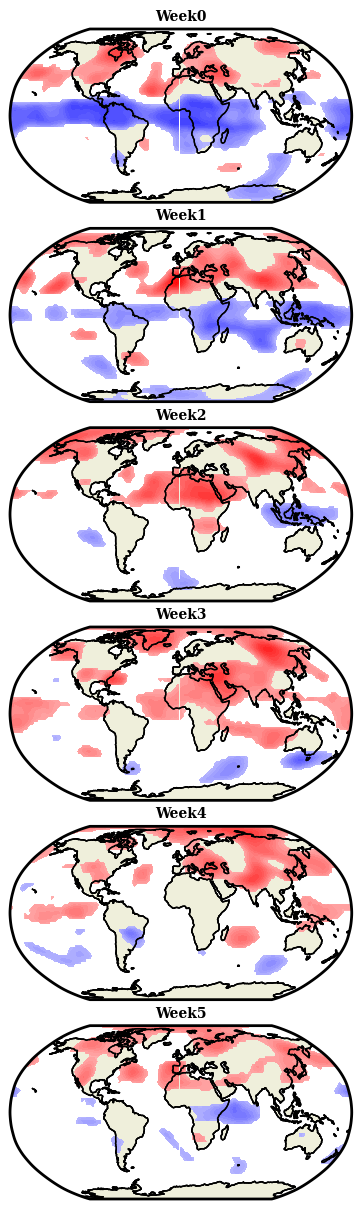

In [31]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the characteristics of the plot
f = plt.figure(figsize=(8, 15))  # define figure size for a single column layout
f.subplots_adjust(right=0.85, bottom=0.1, hspace=0.15)  # adjust space between subplots

axs = []
for i in range(6):
    ax = f.add_subplot(6, 1, i + 1, projection=ccrs.Robinson(central_longitude=0))  # 6 rows, 1 column
    ax.coastlines()  # add coastlines
    #gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)  # add lat/lon gridlines
    #gl.right_labels = False  # remove latitude labels on the right
    #gl.top_labels = False  # remove longitude labels on the top
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')  # add land mask
    axs.append(ax)

# Set the titles and data for each subplot
month = ['Week0', 'Week1', 'Week2', 'Week3', 'Week4', 'Week5']
step_arrows = [gp200_0_days, gp200_7_days, gp200_14_days, gp200_21_days, gp200_28_days, gp200_35_days]

for i in range(len(step_arrows)):
    date = step_arrows[i]
    correD, pvalueD, csig, reg, reg_sig = IndexRegression(date, Index_rain_SNG[:], 0.05)
    axs[i].set_global()
    im = axs[i].contourf(lon, lat, csig.reshape(len(lat), len(lon)), cmap='seismic', levels=np.arange(-0.5, 0.5, 0.01), extend='both', transform=ccrs.PlateCarree())
    axs[i].set_title(month[i], fontsize=10, weight='bold', family='serif')
    axs[i].coastlines()

# Add colorbar
#cbar_ax = f.add_axes([0.88, 0.3, 0.02, 0.4])  # define colorbar location for single column layout
#cbar = f.colorbar(im, cax=cbar_ax)  # display colorbar
#cbar.set_label('csig_gp200_rain_weekly', rotation=270, fontsize=10)  # colorbar label

# Save figure
plt.savefig('/home/wester/Desktop/SST/ERA5/csig_ISO_gp200_Anom_rain_hebdomadaire_colonnes.png', bbox_inches='tight')
plt.show()


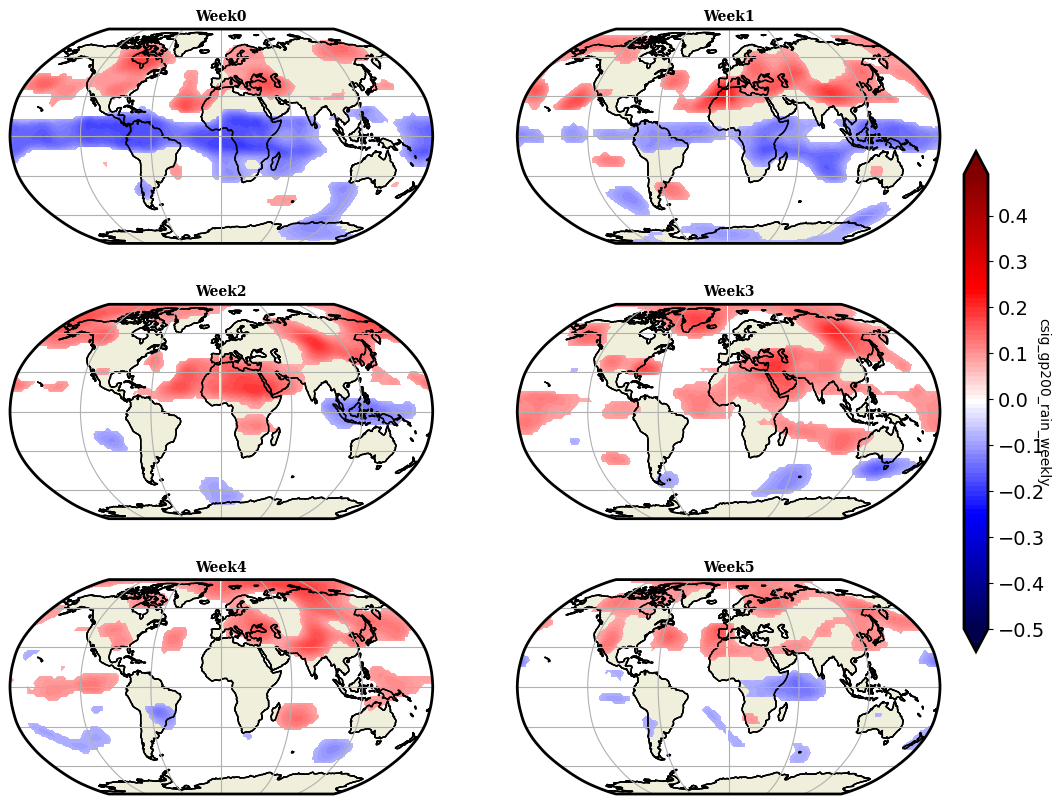

In [32]:
# Define the caracteristics of the plot
f = plt.figure(figsize=(12,10))                                                   # create a figure and define its size
f.subplots_adjust(right = 0.9, bottom = 0.1, hspace= 0.2,wspace=0.2)               # adjust the space between subplots
axs = []
for i in range(6) :
    ax = f.add_subplot(3,2,i+1,projection=ccrs.Robinson(0))                      # the figure will be composed of 3x3 maps
    ax.coastlines()                                                                # add the coastlines
    gl = ax.gridlines(crs=ccrs.PlateCarree())#, draw_labels=True)                    # add the longitude / latitude lines
    #gl.right_labels = False                                                        # remove latitude labels on the right
    #gl.top_labels = False                                                          # remove longitude labels on the top
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')                         # add land mask
    axs.append(ax)
month = ['Week0','Week1','Week2','Week3','Week4','Week5']
step_arrows = [gp200_0_days,gp200_7_days,gp200_14_days,gp200_21_days,gp200_28_days,gp200_35_days]
#step_arrows = [delai_0days_WA, delai_7days_WA, delai_14days_WA, delai_21days_WA, delai_28days_WA]
for i in range(len(step_arrows)):
    date = step_arrows[i]    
    #date = start_date + i
    [correD,pvalueD,csig,reg,reg_sig]=IndexRegression(date,Index_rain_SNG[:],0.05)
    #precip = np.squeeze(pre_all[i,:,:])
    axs[i].set_global()
    im = axs[i].contourf(lon,lat,csig.reshape(len(lat),len(lon)),cmap='seismic', levels=np.arange(-0.5,0.5,0.01),extend='both',transform = ccrs.PlateCarree())
    # add the date in the map titles 
    #axs[i].set_title(np.datetime_as_string(date,unit='m'))
    axs[i].set_title(month[i],fontsize=10, weight='bold',family = 'serif')
    axs[i].coastlines()
    #axs[i].add_feature(cfeat.COASTLINE,edgecolor = 'k')
    #axs[i].add_feature(cfeat.BORDERS, linestyle='-',alpha=1)#Ajouter dans les shapefiles des pays

# Add the titles and legend
#f.suptitle('Figure 1 distribution spatiale des précipitations en juin, juillet, août et septembre en AO sur la période 1981 à 2018',fontsize=14, weight='bold',family = 'serif',y=0.08)                 # add a title to the figure
#axs.set_title('csig_gp200_rain_22_Aout',fontsize=18,weight='bold')
cbar_ax = f.add_axes([0.92, 0.25, 0.02, 0.5])                                       # define the colorbar location
cbar =f.colorbar(im,cax=cbar_ax)                                             # display the colorbar
cbar.set_label('csig_gp200_rain_weekly', rotation=270,fontsize=10)                             # add the title of the colorbar

# Save figure
plt.savefig('/home/wester/Desktop/SST/ERA5/csig_ISO_gp200_Anom_rain_hebdomadaire.png', bbox_inches='tight')
plt.show()

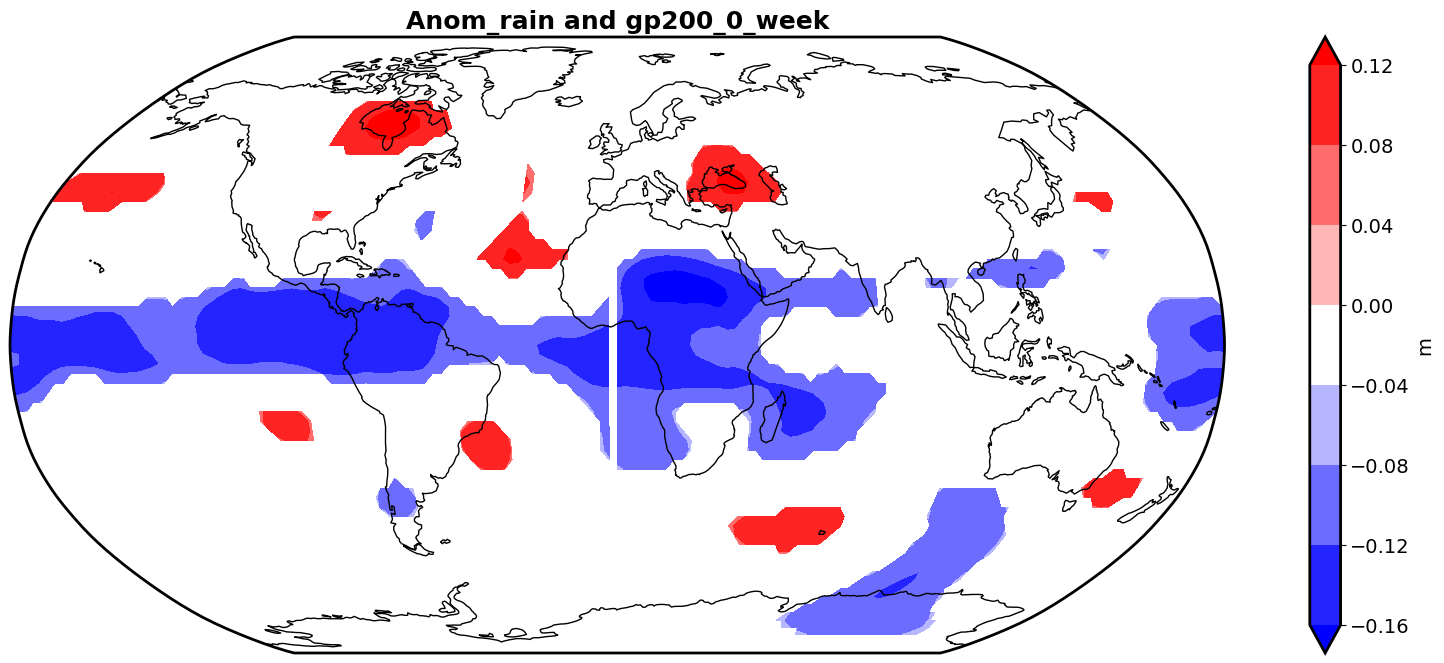

In [33]:
#plot just one map to see if everything is ok
fig = plt.figure(figsize=(22,8)) 
i=1
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(0))

[correD,pvalueD,csig,reg,reg_sig]=IndexRegression(gp200_0_days,Index_rain_SNG[:],0.05)
im = ax.contourf(lon,lat,csig.reshape(len(lat),len(lon)),cmap='bwr',
                 extend='both',transform = ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
fig.colorbar(im,ax=ax,label='m') #Para la barra de colores
ax.grid()
ax.set_title('Anom_rain and gp200_0_week',fontsize=18,weight='bold')
ax.set_ylabel('Lat',fontsize=14)
ax.set_xlabel('lon',fontsize=14);
#plt.savefig('/usr/home/dfaye/SST/ISO_gp200_Hebdomadaire.png',format='png'
#            , bbox_inches='tight')
plt.show(i)
time.sleep(2)

In [25]:
def covariance(x, y):
    [n1,n2]=x.shape
    Cov=ma.empty([n1,])
    for nn in range(n1):
        xx = x[nn,:]-np.nanmean(x[nn,:])
        yy = y-np.nanmean(y)
        zz = 1/float(len(x[nn,:]))
        cov=zz*np.sum(xx*yy)
        Cov[nn]=cov
    return Cov

In [26]:
def somme(x, y):
    [n1,n2]=y.shape
    Summ=ma.empty([n2,])
    for nn in range(n2):
        som=np.sum(x*y[:,nn])
        Summ[nn]=som
    return Summ

In [27]:
#[correD,pvalueD,csig,reg,reg_sig]=IndexRegression(gp200_0_days,Index_rain_SNG[:],0.05)
#delai_0days=csig
Cov_0days=covariance(gp200_0_days,Index_rain_SNG)
preduct_0d=somme(Cov_0days,gp200_0_days)

In [28]:
Cov_7days=covariance(gp200_7_days,Index_rain_SNG)
preduct_7d=somme(Cov_7days,gp200_7_days)

In [29]:
Cov_14days=covariance(gp200_14_days,Index_rain_SNG)
preduct_14d=somme(Cov_14days,gp200_14_days)

In [30]:
Cov_21days=covariance(gp200_21_days,Index_rain_SNG)
preduct_21d=somme(Cov_21days,gp200_21_days)

In [31]:
Cov_28days=covariance(gp200_28_days,Index_rain_SNG)
preduct_28d=somme(Cov_28days,gp200_28_days)

In [32]:
Cov_35days=covariance(gp200_35_days,Index_rain_SNG)
preduct_35d=somme(Cov_35days,gp200_35_days)

In [33]:
weekly_gp200_35d=np.array(preduct_35d)
weekly_gp200_28d=np.array(preduct_28d)
weekly_gp200_21d=np.array(preduct_21d)
weekly_gp200_14d=np.array(preduct_14d)
weekly_gp200_7d=np.array(preduct_7d)
weekly_gp200_0d=np.array(preduct_0d)

In [34]:
#weekly_gp200_0d.shape

In [35]:
np.save('/home/wester/Desktop/SST/ERA5/preduct_0d_weekly_gp200.npy',weekly_gp200_0d)
np.save('/home/wester/Desktop/SST/ERA5/preduct_7d_weekly_gp200.npy',weekly_gp200_7d)
np.save('/home/wester/Desktop/SST/ERA5/preduct_14d_weekly_gp200.npy',weekly_gp200_14d)
np.save('/home/wester/Desktop/SST/ERA5/preduct_21d_weekly_gp200.npy',weekly_gp200_21d)
np.save('/home/wester/Desktop/SST/ERA5/preduct_28d_weekly_gp200.npy',weekly_gp200_28d)
np.save('/home/wester/Desktop/SST/ERA5/preduct_35d_weekly_gp200.npy',weekly_gp200_35d)

# Création des modéles de Machine Learning

In [36]:
GP200_0d=np.load('/home/wester/Desktop/SST/ERA5/preduct_0d_weekly_gp200.npy')
GP200_7d=np.load('/home/wester/Desktop/SST/ERA5/preduct_7d_weekly_gp200.npy')
GP200_14d=np.load('/home/wester/Desktop/SST/ERA5/preduct_14d_weekly_gp200.npy')
GP200_21d=np.load('/home/wester/Desktop/SST/ERA5/preduct_21d_weekly_gp200.npy')
GP200_28d=np.load('/home/wester/Desktop/SST/ERA5/preduct_28d_weekly_gp200.npy')
GP200_35d=np.load('/home/wester/Desktop/SST/ERA5/preduct_35d_weekly_gp200.npy')

In [37]:
GP200_0da=np.reshape(GP200_0d,[1,662])
GP200_7da=np.reshape(GP200_7d,[1,662])
GP200_14da=np.reshape(GP200_14d,[1,662])
GP200_21da=np.reshape(GP200_21d,[1,662])
GP200_28da=np.reshape(GP200_28d,[1,662])
GP200_35da=np.reshape(GP200_35d,[1,662])

In [38]:
GP200_0da.shape

(1, 662)

In [39]:
fname = '/home/wester/Desktop/SST/index_10_60d_rainfall_weekly_JJAS_1982-2019.nc'
ds = xr.open_dataset(fname)
Rain = ds['__xarray_dataarray_variable__'].data
Rain.shape

(662, 100, 140)

In [40]:
index_10_60d=np.reshape(Rain,[662,100*140])

In [41]:
import netCDF4
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

**Dans cette étude**, les signaux ISO des champs atmosphériques et de l'anomalie de précipitaton sont normalisés en utilisant la méthode de **(Yeo et Johnson, 2000)**.

Le calcul des **signaux ISO** a généré des données comprenant à la fois des valeurs positives et négatives. C'est pourquoi nous avons choisi **la transformation de Yeo-Johnson**, qui permet de prendre en compte les valeurs négatives présentes dans les données.


**Dans les modèles de machine learning**, on peut souvent être amené à transformer les variables pour avoir des distributions normales.

# La transformation de Yeo-Johnson

La transformation de Yeo-Johnson est une technique similaire à la transformation de Box-Cox, mais elle **peut être utilisée pour des distributions non normales et avec des valeurs négatives**. Yeo-Johnson **applique une transformation qui est une combinaison de la transformation de puissance et de la transformation logarithmique**. Comme pour Box-Cox, l'algorithme choisit automatiquement la transformation optimale pour maximiser la vraisemblance.

La formule de la transformation de Yeo-Johnson est la suivante :

$$
y(\lambda) =
\begin{cases}
\frac{(y+1)^\lambda - 1}{\lambda} & \text{si } y \geq 0, \lambda \neq 0 \\
\log(y+1) & \text{si } y \geq 0, \lambda = 0 \\
-\frac{(-y+1)^{2-\lambda}-1}{2-\lambda} & \text{si } y < 0, \lambda \neq 2 \\
-\log(-y+1) & \text{si } y < 0, \lambda = 2
\end{cases}
$$

où y est la variable à transformer et lambda est la valeur qui maximise la vraisemblance.

### Avantages de la transformation de Yeo-Johnson

- Peut être utilisée pour des distributions non normales et avec des valeurs négatives.
- Comme pour Box-Cox, la valeur optimale de lambda est choisie automatiquement pour maximiser la vraisemblance.

### Inconvénients de la transformation de Yeo-Johnson

- Peut être plus lente à calculer que la transformation de Box-Cox.
- La transformation peut être instable pour certaines valeurs de lambda.

In [42]:
from sklearn.preprocessing import PowerTransformer
# Initialiser un objet PowerTransformer avec la méthode de Yeo-Johnson
yeo_johnson = PowerTransformer(method='yeo-johnson')

In [43]:
Rain_Index=yeo_johnson.fit_transform(index_10_60d)

In [44]:
aa0=np.transpose(GP200_0da)
aa7=np.transpose(GP200_7da)
aa14=np.transpose(GP200_14da)
aa21=np.transpose(GP200_21da)
aa28=np.transpose(GP200_28da)
aa35=np.transpose(GP200_35da)

In [45]:
aa35.shape

(662, 1)

In [46]:
delai_0days= yeo_johnson.fit_transform(aa0)
delai_7days= yeo_johnson.fit_transform(aa7)
delai_14days= yeo_johnson.fit_transform(aa14)
delai_21days= yeo_johnson.fit_transform(aa21)
delai_28days= yeo_johnson.fit_transform(aa28)
delai_35days= yeo_johnson.fit_transform(aa35)

In [47]:
lead_time=[delai_0days,delai_7days,delai_14days,delai_21days,delai_28days,delai_35days]

In [48]:
rain_Index=np.squeeze(yeo_johnson.fit_transform(np.reshape(Index_rain_SNG,[662,1])))

In [49]:
rain_Index.shape

(662,)

In [50]:
662/17

38.94117647058823

In [51]:
#weekly_rain_SNG

In [52]:
Rain_Index[np.isnan(Rain_Index)]=0

# La régression Ridge

In [53]:
# Fonction pour calculer le coefficient de corrélation avec gestion des NaN
def correlation_coefficient(y_true, y_pred):
    if np.var(y_true) == 0 or np.var(y_pred) == 0:
        return 0  # Si la variance est nulle, la corrélation est 0
    else:
        return pearsonr(y_true, y_pred)[0]

In [54]:
from sklearn.metrics import make_scorer,mean_absolute_error
from sklearn.metrics import make_scorer,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np
n_jobs = -1
# Nombre total de semaines (662) et les 17 semaines de validation par an
total_weeks = 662
weeks_per_year = 17
n_splits = total_weeks // weeks_per_year  # Le nombre de splits

# Créer un split de validation croisée en série temporelle
ts_cv = TimeSeriesSplit(n_splits=n_splits)
# Définition des scores à utiliser pour la validation croisée
scoring_mae = make_scorer(mean_absolute_error)
scoring_corr = make_scorer(correlation_coefficient)
n_jobs = -1

In [55]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error

In [64]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

# Création d'un objet Ridge Regression
Reg_R = Ridge()

# Paramètres à tester pour la recherche de grille
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Définition du score à utiliser pour la recherche de grille
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

# Dictionnaire pour stocker les scores moyens pour chaque horizon de prédiction
mean_scores_mae = []
mean_scores_corr = []

# Boucle sur chaque délai pour effectuer la recherche de grille et obtenir les scores
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
delai_names = ['0days', '7days', '14days', '21days', '28days', '35days']

for delai, name in zip(delais, delai_names):
    # Recherche de grille et validation croisée en une étape
    grid_search = GridSearchCV(Reg_R, param_grid=param_grid, cv=ts_cv, n_jobs=n_jobs, scoring=scoring)
    grid_search.fit(delai, rain_Index)
    
    # Meilleur modèle trouvé par GridSearchCV pour ce délai
    best_model = grid_search.best_estimator_
    
    # Obtenir les scores avec cross_val_score en utilisant le meilleur modèle
    scores = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(mean_absolute_error))
    # Calcul de la moyenne des scores pour ce délai
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)
    
    scores_corr = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    
    #print(f'Best alpha for {name}:', grid_search.best_params_['alpha'])
    print(f'Mean MAE for {name}:', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)
    
# Sauvegarder les scores moyens dans un fichier .npy
S2S = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_geop200_0-35days_Ridge.npy', S2S)
# Sauvegarder les coefficients de corrélation dans un fichier .npy
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_gp200_0-35days_Ridge.npy', S2S_corr)

Mean MAE for 0days: 0.7556483510697046
Mean Correlation for 0days: 0.27102201889029626
Mean MAE for 7days: 0.7618519444701012
Mean Correlation for 7days: 0.27070302824005243
Mean MAE for 14days: 0.7669650299002871
Mean Correlation for 14days: 0.2693083573029349
Mean MAE for 21days: 0.7544301234646739
Mean Correlation for 21days: 0.31282339151728766
Mean MAE for 28days: 0.7494160892776778
Mean Correlation for 28days: 0.32186252071764576
Mean MAE for 35days: 0.7597381452667937
Mean Correlation for 35days: 0.3007467540301392


# Modèle de régression Linéaire

In [65]:
import netCDF4
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

In [66]:
from sklearn.metrics import mean_absolute_error
#from sklearn.model_selection import make_scorer
from sklearn.metrics import mean_absolute_error, make_scorer

In [67]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

# Création d'un objet Linear Regression
Reg_LR = LinearRegression()

# Définition du score à utiliser pour la validation croisée
scoring = make_scorer(mean_absolute_error)

# Dictionnaire pour stocker les scores moyens pour chaque horizon de prédiction
mean_scores_mae = []
mean_scores_corr = []
# Boucle sur chaque délai pour effectuer la validation croisée
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
delai_names = ['0days', '7days', '14days', '21days', '28days', '35days']

for delai, name in zip(delais, delai_names):
    # Effectuer la validation croisée
    scores = cross_val_score(Reg_LR, delai, rain_Index, cv=ts_cv, scoring=scoring)
    
    # Calcul de la moyenne des scores pour ce délai
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)
    scores_corr = cross_val_score(Reg_LR, delai, rain_Index, cv=ts_cv, scoring=scoring_corr)
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    
    print(f'Mean MAE for {name}:', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)
# Sauvegarder les scores moyens dans un fichier .npy
S2S = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_gp200_0-35days_RL.npy', S2S)
# Sauvegarder les coefficients de corrélation dans un fichier .npy
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_gp200_0-35days_RL.npy', S2S_corr)

Mean MAE for 0days: 0.7556483195110807
Mean Correlation for 0days: 0.27102201889029626
Mean MAE for 7days: 0.7618519243951487
Mean Correlation for 7days: 0.27070302824005243
Mean MAE for 14days: 0.7669673788591284
Mean Correlation for 14days: 0.2693083573029349
Mean MAE for 21days: 0.7544301161646951
Mean Correlation for 21days: 0.31282339151728766
Mean MAE for 28days: 0.7494262561581736
Mean Correlation for 28days: 0.32186252071764576
Mean MAE for 35days: 0.7597381188302014
Mean Correlation for 35days: 0.3007467540301391


# Support-vector-regression

In [68]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error

# Création d'un objet SVR
Reg_SVR = SVR()

# Définition des paramètres à tester pour la recherche de grille
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}

# Définition du score à utiliser pour la recherche de grille
scoring = make_scorer(mean_absolute_error)

# Dictionnaire pour stocker les meilleurs scores moyens pour chaque horizon de prédiction
mean_scores_mae = []
mean_scores_corr = []

# Boucle sur chaque délai pour effectuer la recherche de grille et la validation croisée
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
delai_names = ['0days', '7days', '14days', '21days', '28days', '35days']

for delai, name in zip(delais, delai_names):
    # Effectuer une recherche de grille pour trouver les meilleurs hyperparamètres pour chaque délai
    grid_search = GridSearchCV(Reg_SVR, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scoring)
    grid_search.fit(delai, rain_Index)
    
    # Meilleur modèle avec les hyperparamètres optimaux
    best_model = grid_search.best_estimator_
    
    # Validation croisée avec le meilleur modèle pour chaque délai
    scores = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=scoring)
    # Calcul de la moyenne des scores pour ce délai
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)

    scores_corr = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    
    print(f'Mean MAE for {name} (best model):', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)
    
# Sauvegarder les scores moyens dans un fichier .npy
S2S = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_geop200_0-35days_SVR.npy', S2S)
# Sauvegarder les coefficients de corrélation dans un fichier .npy
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_gp200_0-35days_SVR.npy', S2S_corr)

Mean MAE for 0days (best model): 0.7731856690002955
Mean Correlation for 0days: 0.19984624056728323
Mean MAE for 7days (best model): 0.763913881327949
Mean Correlation for 7days: 0.27070302824003106
Mean MAE for 14days (best model): 0.7730266896316226
Mean Correlation for 14days: 0.26718747799030956
Mean MAE for 21days (best model): 0.7689331602392959
Mean Correlation for 21days: 0.304979672378375
Mean MAE for 28days (best model): 0.7523609414584904
Mean Correlation for 28days: 0.3218625207175183
Mean MAE for 35days (best model): 0.7913777574789692
Mean Correlation for 35days: 0.21996190700743132


# Multi-layer Perceptron Regressor (MLPRegressor)

In [69]:
from sklearn.neural_network import MLPRegressor

# Création d'un objet MLP Regressor
Reg_MLP = MLPRegressor(max_iter=1000)

# Définition des paramètres pour la recherche de grille
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}

# Utilisation du score MAE sans inversion de signe
scoring = make_scorer(mean_absolute_error)

# Dictionnaire pour stocker les meilleurs scores moyens pour chaque horizon de prédiction
mean_scores_mae = []
mean_scores_corr = []

# Boucle sur chaque délai pour effectuer la recherche de grille et la validation croisée
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
delai_names = ['0days', '7days', '14days', '21days', '28days', '35days']

for delai, name in zip(delais, delai_names):
    # Effectuer une recherche de grille pour trouver les meilleurs hyperparamètres pour chaque délai
    grid_search = GridSearchCV(Reg_MLP, param_grid=param_grid, cv=ts_cv, n_jobs=-1, scoring=scoring)
    grid_search.fit(delai, rain_Index)
    
    # Meilleur modèle avec les hyperparamètres optimaux
    best_model = grid_search.best_estimator_
    
    # Validation croisée avec le meilleur modèle pour chaque délai
    scores = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=scoring)
    # Calcul de la moyenne des scores pour ce délai
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)

    scores_corr = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    
    print(f'Mean MAE for {name} (best model):', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)
    
# Sauvegarder les scores moyens dans un fichier .npy
S2S = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_geop200_0-35days_MLP.npy', S2S)
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_gp200_0-35days_MLP.npy', S2S_corr)

Mean MAE for 0days (best model): 0.7695630253355545
Mean Correlation for 0days: 0.23402355862219862
Mean MAE for 7days (best model): 0.7661689355999508
Mean Correlation for 7days: 0.23007282062330317
Mean MAE for 14days (best model): 0.7655953353974807
Mean Correlation for 14days: 0.27590943068644935
Mean MAE for 21days (best model): 0.7601280275595399
Mean Correlation for 21days: 0.31153940845649586
Mean MAE for 28days (best model): 0.7472885341078261
Mean Correlation for 28days: 0.33154103158454307
Mean MAE for 35days (best model): 0.7615546498285557
Mean Correlation for 35days: 0.288915901945794


# Random Forest avec GridSearchCV

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

# Définition de l'objet Random Forest Regressor
Reg_RF = RandomForestRegressor()

# Paramètres pour la recherche de grille
param_grid = {
    'n_estimators': [50, 100, 200],      # Nombre d'arbres dans la forêt
    'max_depth': [10, 20, None],         # Profondeur maximale des arbres
    'min_samples_split': [2, 5, 10],     # Minimum d'échantillons pour diviser un nœud
    'min_samples_leaf': [1, 2, 4]        # Minimum d'échantillons dans chaque feuille
}

# Définition du score à utiliser pour l'évaluation
scoring = make_scorer(mean_absolute_error)

# Initialisation de la liste pour les scores moyens pour chaque délai
mean_scores_mae = []
mean_scores_corr = []
# Boucle sur chaque délai pour effectuer la recherche de grille et obtenir les scores
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
delai_names = ['0days', '7days', '14days', '21days', '28days', '35days']
# Boucle pour chaque délai avec recherche de grille et validation croisée
for delai, name in zip(delais, delai_names):
    grid_search = GridSearchCV(Reg_RF, param_grid=param_grid, cv=ts_cv, n_jobs=-1, scoring=scoring)
    grid_search.fit(delai, rain_Index)
    best_model = grid_search.best_estimator_

    # Calculer les scores MAE avec validation croisée pour le meilleur modèle
    scores = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=scoring)
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)

    scores_corr = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    
    print(f'Mean MAE for {name} (best model):', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)
    
# Sauvegarder les résultats
S2S_RF = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_geop200_0-35days_RF.npy', S2S_RF)
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_gp200_0-35days_RF.npy', S2S_corr)

Mean MAE for 0days (best model): 0.8856343384890168
Mean Correlation for 0days: 0.1001224655461987
Mean MAE for 7days (best model): 0.8813926677074478
Mean Correlation for 7days: 0.08003407914033764
Mean MAE for 14days (best model): 0.8887524727283392
Mean Correlation for 14days: 0.09287377038139129
Mean MAE for 21days (best model): 0.8753819350301063
Mean Correlation for 21days: 0.1835000591546109
Mean MAE for 28days (best model): 0.8779104066874525
Mean Correlation for 28days: 0.11018397048311918
Mean MAE for 35days (best model): 0.8630661608589353
Mean Correlation for 35days: 0.15315268216064598


# AdaBoost Regressor avec GridSearchCV

In [59]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Initialisation de l'objet AdaBoost Regressor
Reg_AB = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=5))

# Paramètres pour la recherche de grille
param_grid = {
    'n_estimators': [100, 200, 300, 400],                    # Nombre d'estimateurs
    'learning_rate': [0.01, 0.1, 0.5, 1.0]              # Taux d'apprentissage
}
# Définition du score pour l'évaluation
scoring = make_scorer(mean_absolute_error)

# Liste pour les scores moyens pour chaque délai
mean_scores_mae = []
mean_scores_corr = []

# Boucle sur chaque délai pour effectuer la recherche de grille et obtenir les scores
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
delai_names = ['0days', '7days', '14days', '21days', '28days', '35days']
# Boucle pour chaque délai avec recherche de grille et validation croisée
for delai, name in zip(delais, delai_names):
    grid_search = GridSearchCV(Reg_AB, param_grid=param_grid, cv=ts_cv, n_jobs=-1, scoring=scoring)
    grid_search.fit(delai, rain_Index)
    best_model = grid_search.best_estimator_

    # Calculer les scores MAE avec validation croisée pour le meilleur modèle
    scores = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=scoring)
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)

    scores_corr = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    
    print(f'Mean MAE for {name} (best model):', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)
    
# Sauvegarder les résultats
S2S_AB = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_geop200_0-35days_Adaboost_1982-2019.npy', S2S_AB)
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_gp200_0-35daysAdaboost_1982-2019..npy', S2S_corr)

Mean MAE for 0days (best model): 0.8323134443764504
Mean Correlation for 0days: 0.11363037315185463
Mean MAE for 7days (best model): 0.8159845600432
Mean Correlation for 7days: 0.15868149777507348
Mean MAE for 14days (best model): 0.8391057857722014
Mean Correlation for 14days: 0.15487588670176455
Mean MAE for 21days (best model): 0.79385941365889
Mean Correlation for 21days: 0.2951521669834665
Mean MAE for 28days (best model): 0.7972947999875641
Mean Correlation for 28days: 0.20447651842654713
Mean MAE for 35days (best model): 0.8161579559424403
Mean Correlation for 35days: 0.19080549076049158


In [ ]:
Mean MAE for 0days (best model): 2.5808220477665738
Mean Correlation for 0days: -0.06054160534663773
Mean MAE for 7days (best model): 2.4651697009740285
Mean Correlation for 7days: 0.13180289881865637
Mean MAE for 14days (best model): 2.252456139373894
Mean Correlation for 14days: 0.10184347580580146
Mean MAE for 21days (best model): 2.3364908071366526
Mean Correlation for 21days: 0.0811698550701121
Mean MAE for 28days (best model): 2.4229020258554073
Mean Correlation for 28days: -0.036664162624447966
Mean MAE for 35days (best model): 2.1119579416934635
Mean Correlation for 35days: 0.05991354732139214

# Pour voir la variabilité spatiale du scores

Pour intégrer GridSearchCV dans le calcul pour chaque point de grille et chaque délai, nous devons d'abord trouver les meilleurs hyperparamètres pour chaque délai en utilisant GridSearchCV puis les appliquer dans la boucle pour chaque point de grille.

In [80]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
import numpy as np

# Paramètres pour la recherche de grille
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
scoring = make_scorer(mean_absolute_error)

# Trouver les meilleurs paramètres pour chaque délai
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
best_alphas = []

for delai in delais:
    grid_search = GridSearchCV(Ridge(), param_grid=param_grid, cv=ts_cv, scoring=scoring)
    grid_search.fit(delai, Rain_Index)
    best_alphas.append(grid_search.best_params_['alpha'])

# Initialisation des listes pour stocker les scores pour chaque délai et chaque point de grille
score_0d, score_7d, score_14d, score_21d, score_28d, score_35d = [], [], [], [], [], []

# Boucle pour chaque point de grille
for i in range(len(Rain_Index[1])):
    # Calculer les scores de validation croisée avec les meilleurs alphas pour chaque délai
    score_0da = cross_val_score(Ridge(alpha=best_alphas[0]), delai_0days, Rain_Index[:, i], cv=ts_cv, scoring=scoring)
    score_7da = cross_val_score(Ridge(alpha=best_alphas[1]), delai_7days, Rain_Index[:, i], cv=ts_cv, scoring=scoring)
    score_14da = cross_val_score(Ridge(alpha=best_alphas[2]), delai_14days, Rain_Index[:, i], cv=ts_cv, scoring=scoring)
    score_21da = cross_val_score(Ridge(alpha=best_alphas[3]), delai_21days, Rain_Index[:, i], cv=ts_cv, scoring=scoring)
    score_28da = cross_val_score(Ridge(alpha=best_alphas[4]), delai_28days, Rain_Index[:, i], cv=ts_cv, scoring=scoring)
    score_35da = cross_val_score(Ridge(alpha=best_alphas[5]), delai_35days, Rain_Index[:, i], cv=ts_cv, scoring=scoring)

    # Stocker les scores dans les listes correspondantes
    score_0d.append(score_0da)
    score_7d.append(score_7da)
    score_14d.append(score_14da)
    score_21d.append(score_21da)
    score_28d.append(score_28da)
    score_35d.append(score_35da)

# Calcul de la moyenne des scores pour chaque délai
mean_score_0d = np.mean(score_0d, axis=1)
mean_score_7d = np.mean(score_7d, axis=1)
mean_score_14d = np.mean(score_14d, axis=1)
mean_score_21d = np.mean(score_21d, axis=1)
mean_score_28d = np.mean(score_28d, axis=1)
mean_score_35d = np.mean(score_35d, axis=1)

In [81]:
mean_score_0d[mean_score_0d == 0.] = np.nan
mean_score_7d[mean_score_7d == 0.] = np.nan
mean_score_14d[mean_score_14d == 0.] = np.nan
mean_score_21d[mean_score_21d == 0.] = np.nan
mean_score_28d[mean_score_28d == 0.] = np.nan
mean_score_35d[mean_score_35d == 0.] = np.nan
# Enregistrement des résultats dans un fichier .npy
S2S = [mean_score_0d, mean_score_7d, mean_score_14d, mean_score_21d, mean_score_28d, mean_score_35d]
np.save('/home/wester/Desktop/SST/models_spatial/mae_anom_rainfall_geop200_0-35days_Ridge_grid.npy', S2S)

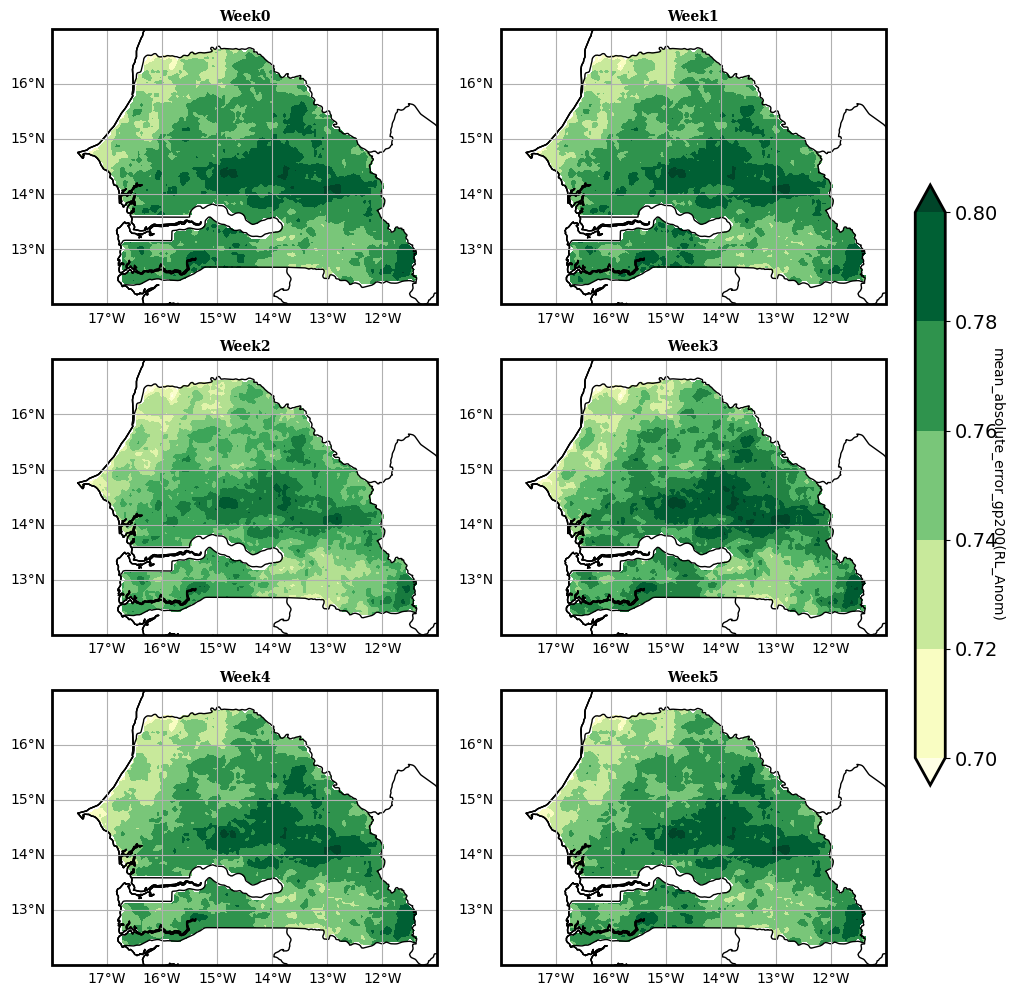

In [82]:
# Define the caracteristics of the plot
f = plt.figure(figsize=(15,12))                                                   # create a figure and define its size
f.subplots_adjust(right = 0.72, bottom = 0.1, hspace= 0.2,wspace=0.01)               # adjust the space between subplots
axs = []
for i in range(6) :
    ax = f.add_subplot(3,2,i+1,projection=ccrs.PlateCarree())                      # the figure will be composed of 3x3 maps
    ax.coastlines()                                                                # add the coastlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)                    # add the longitude / latitude lines
    gl.right_labels = False                                                        # remove latitude labels on the right
    gl.top_labels = False                                                          # remove longitude labels on the top
    #ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')                         # add land mask
    ax.set_extent([-18, -11, 17, 12],crs=ccrs.PlateCarree())
    axs.append(ax)
month = ['Week0','Week1','Week2','Week3','Week4','Week5']
step_arrows = [mean_score_0d, mean_score_7d, mean_score_14d, mean_score_21d, mean_score_28d, mean_score_35d]
for i in range(len(step_arrows)):
    date = step_arrows[i]    
    im = axs[i].contourf(lon1,lat1,date.reshape(len(lat1),len(lon1)),cmap='YlGn', extend='both',transform = ccrs.PlateCarree())
    axs[i].set_title(month[i],fontsize=10, weight='bold',family = 'serif')
    axs[i].coastlines()
    axs[i].add_feature(cfeat.COASTLINE,edgecolor = 'k')
    axs[i].add_feature(cfeat.BORDERS, linestyle='-',alpha=1)
cbar_ax = f.add_axes([0.72, 0.25, 0.02, 0.5])                                       # define the colorbar location
cbar =f.colorbar(im,cax=cbar_ax)                                                   # display the colorbar
cbar.set_label('mean_absolute_error_gp200(RL_Anom)', rotation=270,fontsize=10)                             # add the title of the colorbar
#plt.subplots_adjust(hspace=0.3)
# Save figure
plt.savefig('/home/wester/Desktop/SST/ERA5/prevision_Anom_rain_modele_leniaire_mae.png', bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
import numpy as np

# Paramètres pour la recherche de grille
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
scoring = make_scorer(mean_absolute_error)

# Trouver les meilleurs paramètres pour chaque délai
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
best_alphas = []

for delai in delais:
    grid_search = GridSearchCV(Ridge(), param_grid=param_grid, cv=ts_cv, scoring=scoring)
    grid_search.fit(delai, Rain_Index)
    best_alphas.append(grid_search.best_params_['alpha'])

# Initialisation des listes pour stocker les scores pour chaque délai et chaque point de grille
score_0d, score_7d, score_14d, score_21d, score_28d, score_35d = [], [], [], [], [], []

# Boucle pour chaque point de grille
for i in range(len(Rain_Index[1])):
    # Calculer les scores de validation croisée avec les meilleurs alphas pour chaque délai
    score_0da = cross_val_score(Ridge(alpha=best_alphas[0]), delai_0days, Rain_Index[:, i], cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    score_7da = cross_val_score(Ridge(alpha=best_alphas[1]), delai_7days, Rain_Index[:, i], cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    score_14da = cross_val_score(Ridge(alpha=best_alphas[2]), delai_14days, Rain_Index[:, i], cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    score_21da = cross_val_score(Ridge(alpha=best_alphas[3]), delai_21days, Rain_Index[:, i], cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    score_28da = cross_val_score(Ridge(alpha=best_alphas[4]), delai_28days, Rain_Index[:, i], cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    score_35da = cross_val_score(Ridge(alpha=best_alphas[5]), delai_35days, Rain_Index[:, i], cv=ts_cv, scoring=make_scorer(correlation_coefficient))

    # Stocker les scores dans les listes correspondantes
    score_0d.append(score_0da)
    score_7d.append(score_7da)
    score_14d.append(score_14da)
    score_21d.append(score_21da)
    score_28d.append(score_28da)
    score_35d.append(score_35da)

# Calcul de la moyenne des scores pour chaque délai
mean_score_0d = np.mean(score_0d, axis=1)
mean_score_7d = np.mean(score_7d, axis=1)
mean_score_14d = np.mean(score_14d, axis=1)
mean_score_21d = np.mean(score_21d, axis=1)
mean_score_28d = np.mean(score_28d, axis=1)
mean_score_35d = np.mean(score_35d, axis=1)

In [ ]:
mean_score_0d[mean_score_0d == 0.] = np.nan
mean_score_7d[mean_score_7d == 0.] = np.nan
mean_score_14d[mean_score_14d == 0.] = np.nan
mean_score_21d[mean_score_21d == 0.] = np.nan
mean_score_28d[mean_score_28d == 0.] = np.nan
mean_score_35d[mean_score_35d == 0.] = np.nan
# Enregistrement des résultats dans un fichier .npy
S2S = [mean_score_0d, mean_score_7d, mean_score_14d, mean_score_21d, mean_score_28d, mean_score_35d]
np.save('/home/wester/Desktop/SST/models_spatial/ACC_anom_rainfall_geop200_0-35days_Ridge_grid.npy', S2S)

In [ ]:
# Define the caracteristics of the plot
f = plt.figure(figsize=(15,12))                                                   # create a figure and define its size
f.subplots_adjust(right = 0.72, bottom = 0.1, hspace= 0.2,wspace=0.01)               # adjust the space between subplots
axs = []
for i in range(6) :
    ax = f.add_subplot(3,2,i+1,projection=ccrs.PlateCarree())                      # the figure will be composed of 3x3 maps
    ax.coastlines()                                                                # add the coastlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)                    # add the longitude / latitude lines
    gl.right_labels = False                                                        # remove latitude labels on the right
    gl.top_labels = False                                                          # remove longitude labels on the top
    #ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')                         # add land mask
    ax.set_extent([-18, -11, 17, 12],crs=ccrs.PlateCarree())
    axs.append(ax)
month = ['Week0','Week1','Week2','Week3','Week4','Week5']
step_arrows = [mean_score_0d, mean_score_7d, mean_score_14d, mean_score_21d, mean_score_28d, mean_score_35d]
for i in range(len(step_arrows)):
    date = step_arrows[i]    
    im = axs[i].contourf(lon1,lat1,date.reshape(len(lat1),len(lon1)),cmap='YlGn', extend='both',transform = ccrs.PlateCarree())
    axs[i].set_title(month[i],fontsize=10, weight='bold',family = 'serif')
    axs[i].coastlines()
    axs[i].add_feature(cfeat.COASTLINE,edgecolor = 'k')
    axs[i].add_feature(cfeat.BORDERS, linestyle='-',alpha=1)
cbar_ax = f.add_axes([0.72, 0.25, 0.02, 0.5])                                       # define the colorbar location
cbar =f.colorbar(im,cax=cbar_ax)                                                   # display the colorbar
cbar.set_label('ACC_gp200', rotation=270,fontsize=10)                             # add the title of the colorbar
#plt.subplots_adjust(hspace=0.3)
# Save figure
plt.savefig('/home/wester/Desktop/SST/ERA5/prevision_Anom_rain_modele_leniaire_ACC_gp200.png', bbox_inches='tight')
plt.show()